# Evaluation Script

In [1]:
import torch.nn.functional as F
from sklearn import metrics
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import h5py
from sklearn.metrics import roc_curve, auc, balanced_accuracy_score
from sklearn.metrics import confusion_matrix
from matplotlib.lines import Line2D

# Global Variables

In [45]:
# global variables
ensemble_size = 10
n_deferral = 10
t = 15 # number of uncertainty thresholds
batch_size = 4

# Functions

## per-class Acc

## bAcc with replacement

## bAcc without replacement

In [48]:
def get_data(ensemble, single, deferral, deferral_liu, swag, mc, bbb, labels):
    length = ensemble.shape[0]

    # ------- ensemble -------
    data_ensemble = []
    # compute uncertainties
    ensemble_uncertainties = ensemble.var(axis=1, dtype=np.float64)
    sigma = ensemble.std(axis=1, dtype=np.float64).mean()
    ensemble_mean = ensemble.mean(axis=1)
    ensemble_pred = ensemble_mean.argmax(axis=1) # mean prediction

    # compute bacc and number of deferred for all thresholds
    for i in np.linspace(3*sigma, 0, 200, endpoint=True):
        mask = ensemble_uncertainties[:, 1] >= i # mask shows all deferred images, i.e. those with uncertainty above threshold

        ensemble_mean_copy = ensemble_mean.copy()
        rate = np.sum(mask) / length # perecentage of deferred images

        # ratio of classes of deferred images
        label_values, c = np.unique(labels[mask], return_counts=True)
        counts = np.zeros(2)
        counts[label_values] = c

        if mask.all():
            bacc = np.nan
        else:
            bacc = balanced_accuracy_score(labels[~mask], ensemble_pred[~mask])
        data = np.array([rate, bacc])
        data = np.concatenate((data, counts))
        data_ensemble.append(data)

    data_ensemble = np.stack(data_ensemble) # now includes 50 tuples of rate and bacc

    
    # ------- swag -------
    data_swag = []
    # compute uncertainties
    swag_uncertainties = swag.var(axis=1, dtype=np.float64)
    sigma = swag.std(axis=1, dtype=np.float64).mean()
    swag_mean = swag.mean(axis=1)
    swag_pred = swag_mean.argmax(axis=1) # mean prediction

    # compute bacc and number of deferred for all thresholds
    for i in np.linspace(3*sigma, 0, 200, endpoint=True):
        mask = swag_uncertainties[:, 1] >= i # mask shows all deferred images, i.e. those with uncertainty above threshold

        swag_mean_copy = swag_mean.copy()
        rate = np.sum(mask) / length # perecentage of deferred images

        # ratio of classes of deferred images
        label_values, c = np.unique(labels[mask], return_counts=True)
        counts = np.zeros(2)
        counts[label_values] = c

        if mask.all():
            bacc = np.nan
        else:
            bacc = balanced_accuracy_score(labels[~mask], swag_pred[~mask])
        data = np.array([rate, bacc])
        data = np.concatenate((data, counts))
        data_swag.append(data)

    data_swag = np.stack(data_swag) # now includes 50 tuples of rate and bacc

    # ------- mc -------
    data_mc = []
    # compute uncertainties
    mc_uncertainties = mc.var(axis=1, dtype=np.float64)
    sigma = mc.std(axis=1, dtype=np.float64).mean()
    mc_mean = mc.mean(axis=1)
    mc_pred = mc_mean.argmax(axis=1) # mean prediction

    # compute bacc and number of deferred for all thresholds
    for i in np.linspace(3*sigma, 0, 200, endpoint=True):
        mask = mc_uncertainties[:, 1] >= i # mask shows all deferred images, i.e. those with uncertainty above threshold

        mc_mean_copy = mc_mean.copy()
        rate = np.sum(mask) / length # perecentage of deferred images

        # ratio of classes of deferred images
        label_values, c = np.unique(labels[mask], return_counts=True)
        counts = np.zeros(2)
        counts[label_values] = c

        if mask.all():
            bacc = np.nan
        else:
            bacc = balanced_accuracy_score(labels[~mask], mc_pred[~mask])
        data = np.array([rate, bacc])
        data = np.concatenate((data, counts))
        data_mc.append(data)

    data_mc = np.stack(data_mc) # now includes 50 tuples of rate and bacc

    # ------- bbb -------
    data_bbb = []
    # compute uncertainties
    bbb_uncertainties = bbb.var(axis=1, dtype=np.float64)
    sigma = bbb.std(axis=1, dtype=np.float64).mean()
    bbb_mean = bbb.mean(axis=1)
    bbb_pred = bbb_mean.argmax(axis=1) # mean prediction

    # compute bacc and number of deferred for all thresholds
    for i in np.linspace(3*sigma, 0, 200, endpoint=True):
        mask = bbb_uncertainties[:, 1] >= i # mask shows all deferred images, i.e. those with uncertainty above threshold

        bbb_mean_copy = bbb_mean.copy()
        bbb_mean_copy[mask, 1] = labels[mask] # replace labels of all deferred images with ground truth (assume that humans make perfect decisions when deferred to)
        rate = np.sum(mask) / length # perecentage of deferred images

        # ratio of classes of deferred images
        label_values, c = np.unique(labels[mask], return_counts=True)
        counts = np.zeros(2)
        counts[label_values] = c

        if mask.all():
            bacc = np.nan
        else:
            bacc = balanced_accuracy_score(labels[~mask], bbb_pred[~mask])
        data = np.array([rate, bacc])
        data = np.concatenate((data, counts))
        data_bbb.append(data)

    data_bbb = np.stack(data_bbb) # now includes 50 tuples of rate and bacc

    # ------- single -------
    # uncertainties aka softmax
    single_uncertainties = 1 - 2* np.abs(single - 0.5) # softmax = 0.5 euqals highest uncertainty aka 1; softmax 0 or 1 euqals lowest uncertainty aka 0
    # ------- single -------
    data_single = [] 
    single_pred = single.argmax(axis=1)
    # compute bacc and number of deferred for all thresholds
    for i in np.linspace(1, 0, 200, endpoint=True):
        mask = single_uncertainties >= i # mask shows all deferred images, i.e. those with uncertainty above threshold
        mask = mask[:, 1] # only interested in class 1 predictions

        rate = np.sum(mask) / length # perecentage of deferred images

        # ratio of classes of deferred images
        label_values, c = np.unique(labels[mask], return_counts=True)
        counts= np.zeros(2)
        counts[label_values] = c

        if mask.all():
            bacc = np.nan
        else:
            bacc = balanced_accuracy_score(labels[~mask], single_pred[~mask])

        data = np.array([rate, bacc])
        data = np.concatenate((data, counts))
        data_single.append(data)

    data_single = np.stack(data_single) # now includes 50 tuples of rate and bacc

    # ------- deferral -------
    data_deferral = []
    deferral_preds = np.argmax(deferral, axis=2) # predictions
    for i in range(n_deferral):

        deferral_preds_copy = deferral_preds[:, i].copy() # copy to not replace labels in place or following models will automatically become better and better
        mask = deferral_preds_copy == 2 # mask shows all deferred images, i.e. those with predicited class = deferral class
        deferral_copy = deferral.copy()

        # ratio of classes of deferred images
        label_values, c = np.unique(labels[mask], return_counts=True)
        counts = np.zeros(2)
        counts[label_values] = c

        if mask.all():
            bacc = np.nan
        else:
            bacc = balanced_accuracy_score(labels[~mask], deferral_preds[~mask, i])
        rate = np.sum(mask) / length # perecentage of deferred images

        data = np.array([rate, bacc])
        data = np.concatenate((data, counts))
        data_deferral.append(data)

    data_deferral = np.stack(data_deferral) # now includes 10 tuples of rate and bacc

    # ------- deferral liu -------
    data_deferral_liu = []
    deferral_preds_liu = np.argmax(deferral_liu, axis=2) # predictions
    for i in range(n_deferral):

        deferral_preds_copy_liu = deferral_preds_liu[:, i].copy() # copy to not replace labels in place or following models will automatically become better and better
        mask = deferral_preds_copy_liu == 2 # mask shows all deferred images, i.e. those with predicited class = deferral class

        # ratio of classes of deferred images
        label_values, c = np.unique(labels[mask], return_counts=True)
        counts = np.zeros(2)
        counts[label_values] = c

        if mask.all():
            bacc = np.nan
        else:
            bacc = balanced_accuracy_score(labels[~mask], deferral_preds_liu[~mask, i])
        rate = np.sum(mask) / length # perecentage of deferred images

        data = np.array([rate, bacc])
        data = np.concatenate((data, counts))
        data_deferral_liu.append(data)

    data_deferral_liu = np.stack(data_deferral_liu) # now includes 10 tuples of rate and bacc

    
    return data_ensemble, data_single, data_deferral, data_deferral_liu, data_swag, data_mc, data_bbb

In [49]:
def get_data_level(ensemble, single, deferral, deferral_liu, swag, mc, bbb, levels_ood, labels_ood):

    # ------- ensemble -------
    # compute uncertainties
    ensemble_uncertainties = ensemble.var(axis=1, dtype=np.float64)
    sigma = ensemble.std(axis=1, dtype=np.float64).mean()
    ensemble_mean = ensemble.mean(axis=1)
    ensemble_pred = ensemble_mean.argmax(axis=1) # mean prediction

    data_ensemble = []

    for l in range(1, 6):
        mask_level = (levels_ood == l) | (levels_ood == 0) # get all images of level zero (in domain) and level l
        ood = levels_ood == l
        ood_level = ood[mask_level] # only the level l images
        ensemble_pred_level = ensemble_pred[mask_level].copy() # to make sure not to replace labels in place
        labels_level = labels_ood[mask_level] # the corresponding labels for the subset of images
        ensemble_uncertainties_level = ensemble_uncertainties[mask_level] # the corresponding uncertainties for the subset of images

        data_ensemble_level = []

        length = ensemble_pred_level.shape[0] # total number of images of this subset (0 and l images)

        for i in np.linspace(3*sigma, 0, 200, endpoint=True):
            mask = ensemble_uncertainties_level >= i # mask shows all deferred images, i.e. those with uncertainty above threshold
            mask = mask[:, 1] # only interested in class 1 predictions

            # ratio of classes of deferred images
            label_values, c = np.unique(labels_level[mask], return_counts=True)
            counts = np.zeros(2)
            counts[label_values] = c

            if mask.all():
                bacc = np.nan
            else:
                bacc = balanced_accuracy_score(labels_level[~mask], ensemble_pred_level[~mask])

            # rate of deferrals
            rate = np.sum(mask) / length # percentage of deferred images

            data = np.array([rate, bacc])
            data = np.concatenate((data, counts))

            # Append results
            data_ensemble_level.append(data)


        data_ensemble_level = np.stack(data_ensemble_level)
        data_ensemble.append(data_ensemble_level)

    data_ensemble = np.stack(data_ensemble)
    assert data_ensemble.shape == (5, 200,  4), f"Data ensemble shape: {data_ensemble.shape}" # five levels of ood x uncertainty thesholds x rate, bacc, perecnetage_ood

    # ------- swag -------
    # compute uncertainties
    swag_uncertainties = swag.var(axis=1, dtype=np.float64)
    sigma = swag.std(axis=1, dtype=np.float64).mean()
    swag_mean = swag.mean(axis=1)
    swag_pred = swag_mean.argmax(axis=1) # mean prediction

    data_swag = []

    for l in range(1, 6):
        mask_level = (levels_ood == l) | (levels_ood == 0) # get all images of level zero (in domain) and level l
        ood = levels_ood == l
        ood_level = ood[mask_level] # only the level l images
        swag_pred_level = swag_pred[mask_level].copy() # to make sure not to replace labels in place
        labels_level = labels_ood[mask_level] # the corresponding labels for the subset of images
        swag_uncertainties_level = swag_uncertainties[mask_level] # the corresponding uncertainties for the subset of images

        data_swag_level = []

        length = swag_pred_level.shape[0] # total number of images of this subset (0 and l images)

        for i in np.linspace(3*sigma, 0, 200, endpoint=True):
            mask = swag_uncertainties_level >= i # mask shows all deferred images, i.e. those with uncertainty above threshold
            mask = mask[:, 1] # only interested in class 1 predictions

            # ratio of classes of deferred images
            label_values, c = np.unique(labels_level[mask], return_counts=True)
            counts = np.zeros(2)
            counts[label_values] = c

            if mask.all():
                bacc = np.nan
            else:
                bacc = balanced_accuracy_score(labels_level[~mask], swag_pred_level[~mask])

            # rate of deferrals
            rate = np.sum(mask) / length # percentage of deferred images

            # Append results
            data = np.array([rate, bacc])
            data = np.concatenate((data, counts))
            data_swag_level.append(data)

        data_swag_level = np.stack(data_swag_level)
        data_swag.append(data_swag_level)

    data_swag = np.stack(data_swag)
    assert data_swag.shape == (5, 200,  4), f"Data swag shape: {data_swag.shape}" # five levels of ood x uncertainty thesholds x rate, bacc, perecnetage_ood

    # ------- bbb -------
    # compute uncertainties
    bbb_uncertainties = bbb.var(axis=1, dtype=np.float64)
    sigma = bbb.std(axis=1, dtype=np.float64).mean()
    bbb_mean = bbb.mean(axis=1)
    bbb_pred = bbb_mean.argmax(axis=1) # mean prediction

    data_bbb = []

    for l in range(1, 6):
        mask_level = (levels_ood == l) | (levels_ood == 0) # get all images of level zero (in domain) and level l
        ood = levels_ood == l
        ood_level = ood[mask_level] # only the level l images
        bbb_pred_level = bbb_pred[mask_level].copy() # to make sure not to replace labels in place
        labels_level = labels_ood[mask_level] # the corresponding labels for the subset of images
        bbb_uncertainties_level = bbb_uncertainties[mask_level] # the corresponding uncertainties for the subset of images

        data_bbb_level = []

        length = bbb_pred_level.shape[0] # total number of images of this subset (0 and l images)

        for i in np.linspace(3*sigma, 0, 200, endpoint=True):
            mask = bbb_uncertainties_level >= i # mask shows all deferred images, i.e. those with uncertainty above threshold
            mask = mask[:, 1] # only interested in class 1 predictions

            # ratio of classes of deferred images
            label_values, c = np.unique(labels_level[mask], return_counts=True)
            counts = np.zeros(2)
            counts[label_values] = c

            if mask.all():
                bacc = np.nan
            else:
                bacc = balanced_accuracy_score(labels_level[~mask], bbb_pred_level[~mask])

            # rate of deferrals
            rate = np.sum(mask) / length # percentage of deferred images

            # Append results
            data = np.array([rate, bacc])
            data = np.concatenate((data, counts))
            data_bbb_level.append(data)

        data_bbb_level = np.stack(data_bbb_level)
        data_bbb.append(data_bbb_level)

    data_bbb = np.stack(data_bbb)
    assert data_bbb.shape == (5, 200,  4), f"Data bbb shape: {data_bbb.shape}" # five levels of ood x uncertainty thesholds x rate, bacc, perecnetage_ood
    # ------- mc -------
    # compute uncertainties
    mc_uncertainties = mc.var(axis=1, dtype=np.float64)
    sigma = mc.std(axis=1, dtype=np.float64).mean()
    mc_mean = mc.mean(axis=1)
    mc_pred = mc_mean.argmax(axis=1) # mean prediction

    data_mc = []

    for l in range(1, 6):
        mask_level = (levels_ood == l) | (levels_ood == 0) # get all images of level zero (in domain) and level l
        ood = levels_ood == l
        ood_level = ood[mask_level] # only the level l images
        mc_pred_level = mc_pred[mask_level].copy() # to make sure not to replace labels in place
        labels_level = labels_ood[mask_level] # the corresponding labels for the subset of images
        mc_uncertainties_level = mc_uncertainties[mask_level] # the corresponding uncertainties for the subset of images

        data_mc_level = []

        length = mc_pred_level.shape[0] # total number of images of this subset (0 and l images)

        for i in np.linspace(3*sigma, 0, 200, endpoint=True):
            mask = mc_uncertainties_level >= i # mask shows all deferred images, i.e. those with uncertainty above threshold
            mask = mask[:, 1] # only interested in class 1 predictions

            # ratio of classes of deferred images
            label_values, c = np.unique(labels_level[mask], return_counts=True)
            counts = np.zeros(2)
            counts[label_values] = c

            # bacc before removal
            if mask.all():
                bacc = np.nan
            else:
                bacc = balanced_accuracy_score(labels_level[~mask], mc_pred_level[~mask])

            # rate of deferrals
            rate = np.sum(mask) / length # percentage of deferred images

            # Append results
            data = np.array([rate, bacc])
            data = np.concatenate((data, counts))
            data_mc_level.append(data)

        data_mc_level = np.stack(data_mc_level)
        data_mc.append(data_mc_level)

    data_mc = np.stack(data_mc)
    assert data_mc.shape == (5, 200,  4), f"Data mc shape: {data_mc.shape}" # five levels of ood x uncertainty thesholds x rate, bacc, perecnetage_ood
    # ------- single -------
    single_uncertainties = 1 - 2* np.abs(single - 0.5) # (see above for details)
    # uncertainties aka softmax 
    single_pred = single.argmax(axis=1) # predictions

    data_single = []

    for l in range(1, 6):
        mask_level = (levels_ood == l) | (levels_ood == 0) # get all images of level zero (in domain) and level l
        ood = levels_ood == l
        ood_level = ood[mask_level] # only the level l images
        single_pred_level = single_pred[mask_level].copy() # to make sure not to replace labels in place
        labels_level = labels_ood[mask_level] # the corresponding labels for the subset of images
        single_uncertainties_level = single_uncertainties[mask_level] # the corresponding uncertainties for the subset of images


        data_single_level = []

        length = labels_level.shape[0] # total number of images of this subset (0 and l images)

        for i in np.linspace(1, 0, 200, endpoint=True):
            mask = single_uncertainties_level >= i # mask shows all deferred images, i.e. those with uncertainty above threshold
            mask = mask[:, 1] # only interested in class 1 predictions
            
            # ratio of classes of deferred images
            label_values, c = np.unique(labels_level[mask], return_counts=True)
            counts = np.zeros(2)
            counts[label_values] = c
            
            # bacc before removal
            if mask.all():
                bacc = np.nan
            else:
                bacc = balanced_accuracy_score(labels_level[~mask], single_pred_level[~mask])

            # Number of deferrals
            rate = np.sum(mask) / length # precentage of deferred images

            # Append results
            data = np.array([rate, bacc])
            data = np.concatenate((data, counts))
            data_single_level.append(data)

        data_single_level = np.stack(data_single_level)
        data_single.append(data_single_level)

    data_single = np.stack(data_single)
    assert data_single.shape == (5, 200,  4), f"Data single shape: {data_single.shape}" # five levels of ood x uncertainty thesholds x rate, bacc, perecnetage_ood
    # ------- deferral -------
    data_deferral = []
    deferral_preds = np.argmax(deferral, axis=2) # predictions
    for l in range(1, 6):
        mask_level = (levels_ood[:] == l) | (levels_ood[:] == 0) # get all images of level zero (in domain) and level l
        ood = levels_ood[:] == l
        ood_level = ood[mask_level] # only the level l images
        deferral_pred_level = deferral_preds[mask_level] # the corresponding predictions for the subset of images
        labels_level = labels_ood[mask_level] # the corresponding labels for the subset of images

        data_deferral_level = []

        length = deferral_pred_level.shape[0]
        
        for i in range(n_deferral): # for all levels of deferral cost
            mask = deferral_pred_level[:,i] == 2 # mask shows all deferred images, i.e. those with predicited class = deferral class

            # ratio of classes of deferred images
            label_values, c = np.unique(labels_level[mask], return_counts=True)
            counts = np.zeros(2)
            counts[label_values] = c

            if mask.all():
                bacc = np.nan
            else:
                bacc = balanced_accuracy_score(labels_level[~mask], deferral_pred_level[~mask,i])
            rate = np.sum(mask) / length

            # Append results
            data = np.array([rate, bacc])
            data = np.concatenate((data, counts))
            data_deferral_level.append(data)
        
        data_deferral_level = np.stack(data_deferral_level)
        data_deferral.append(data_deferral_level)

    data_deferral = np.stack(data_deferral)
    assert data_deferral.shape == (5, n_deferral,  4), f"Data deferral shape: {data_deferral.shape}" # five levels of ood x number of deferral models x rate, bacc, percentage_ood

    # ------- deferral -------
    data_deferral_liu = []
    deferral_preds_liu = np.argmax(deferral_liu, axis=2) # predictions
    for l in range(1, 6):
        mask_level = (levels_ood[:] == l) | (levels_ood[:] == 0) # get all images of level zero (in domain) and level l
        ood = levels_ood[:] == l
        ood_level = ood[mask_level] # only the level l images
        deferral_pred_level_liu = deferral_preds_liu[mask_level] # the corresponding predictions for the subset of images
        labels_level = labels_ood[mask_level] # the corresponding labels for the subset of images

        data_deferral_level_liu = []

        length = deferral_pred_level_liu.shape[0]
        
        for i in range(n_deferral): # for all levels of deferral cost
            mask = deferral_pred_level_liu[:,i] == 2 # mask shows all deferred images, i.e. those with predicited class = deferral class

            # ratio of classes of deferred images
            label_values, c = np.unique(labels_level[mask], return_counts=True)
            counts = np.zeros(2)
            counts[label_values] = c

            if mask.all():
                bacc = np.nan
            else:
                bacc = balanced_accuracy_score(labels_level[~mask], deferral_pred_level_liu[~mask,i])
            rate = np.sum(mask) / length

            # Append results
            data = np.array([rate, bacc])
            data = np.concatenate((data, counts))
            data_deferral_level_liu.append(data)
        
        data_deferral_level_liu = np.stack(data_deferral_level_liu)
        data_deferral_liu.append(data_deferral_level_liu)

    data_deferral_liu = np.stack(data_deferral_liu)

    return data_ensemble, data_single, data_deferral, data_deferral_liu, data_swag, data_mc, data_bbb

# In Domain

## Load data

In [50]:
# in domain data
hdf5_file = h5py.File("/AIROGS.h5", "r")
labels = hdf5_file["test/diagnosis"][:]

In [53]:
model_outs_swag = np.load("/SWAG_outs.npz")
swag = model_outs_swag["predictions"]
swag = np.swapaxes(swag,0,1)
print(swag.shape)

(10145, 10, 2)


In [54]:
model_outs_bbb = np.load("/bbb_out.npz")

In [55]:
model_outs_mcdropout = np.load("/mcdropout_out.npz")

In [56]:
# loading model outputs
model_outs = np.load("/model_outs.npz")
ensemble = model_outs["ensemble"]
single = model_outs["single"]
deferral = model_outs["deferral"]
deferral_liu = np.load("/model_outs_liu.npz")
deferral_liu = deferral_liu["deferral_liu"]
# remove last zero entries (due to batches)
ensemble = ensemble.reshape(-1, 10, 2)
ensemble = np.delete(ensemble, [10145, 10146, 10147], 0)
print(ensemble.shape) # number of images x number of models in ensemble x output classes
mc = model_outs_mcdropout["predictions"]
bbb = model_outs_bbb["predictions"]
# remove last zero entries (due to batches)
single = single.reshape(-1, 2)
single = np.delete(single, [10145, 10146, 10147], 0)
print(single.shape) # number of images x output classes
# remove last zero entries (due to batches)
deferral = deferral.reshape(-1, n_deferral, 3)
deferral = np.delete(deferral, [10145, 10146, 10147], 0)
print(deferral.shape)
# remove last zero entries (due to batches)
deferral_liu = deferral_liu.reshape(-1, n_deferral, 3)
deferral_liu = np.delete(deferral_liu, [10145, 10146, 10147], 0)
print(deferral_liu.shape)

(10145, 10, 2)
(10145, 2)
(10145, 10, 3)
(10145, 2, 3)
(10145, 10, 3)


## Classification Performance in domain
**Question:** Does the model perform well on its original classification task?

**Experiment:** Computing AUC, bAcc and per-class Acc of the model on the in-domain dataset.

In [57]:
def compute_metrics(name, targets, predictions):
    fpr, tpr, _ = roc_curve(targets, predictions[:, 1])
    roc_auc = auc(fpr, tpr)
    pred_labels = predictions.argmax(axis=1)
    bacc = balanced_accuracy_score(labels, pred_labels)
    cm = confusion_matrix(labels, pred_labels)
    per_class_acc = cm.diagonal() / cm.sum(axis=1)
    return {
        "Model": name,
        "AUC": roc_auc,
        "Balanced Accuracy": bacc,
        "Per-Class Accuracy": per_class_acc
    }

results = []

metrics_bbb = compute_metrics("Bayesian", model_outs_bbb["targets"], bbb.mean(axis=1))
results.append(metrics_bbb)

metrics_mc = compute_metrics("MC Dropout", model_outs_mcdropout["targets"], mc.mean(axis=1))
results.append(metrics_mc)

metrics_swag = compute_metrics("SWAG", model_outs_swag["targets"], swag.mean(axis=1))
results.append(metrics_swag)

metrics_ensemble = compute_metrics("Ensemble", labels, ensemble.mean(axis=1))
results.append(metrics_ensemble)

metrics_single = compute_metrics("Softmax", labels, single)
results.append(metrics_single)

# deferral
fpr_deferral, tpr_deferral, _ = roc_curve(labels, deferral[:, 9, 1])
roc_auc_deferral = metrics.auc(fpr_deferral, tpr_deferral)
bacc_deferral = balanced_accuracy_score(labels, deferral[:, 9].argmax(axis=1))
cm = confusion_matrix(labels, deferral[:, 9].argmax(axis=1))
per_class_acc_deferral = cm.diagonal() / cm.sum(axis=1)
metrics_deferral = {
        "Model": "Deferral Model",
        "AUC": roc_auc_deferral,
        "Balanced Accuracy": bacc_deferral,
        "Per-Class Accuracy": per_class_acc_deferral
    }
results.append(metrics_deferral)

# deferral liu
fpr_deferral_liu, tpr_deferral_liu, _ = roc_curve(labels, deferral_liu[:, 0, 1])
roc_auc_deferral_liu = metrics.auc(fpr_deferral_liu, tpr_deferral_liu)
bacc_deferral_liu = balanced_accuracy_score(labels, deferral_liu[:, 0].argmax(axis=1))
cm = confusion_matrix(labels, deferral_liu[:, 0].argmax(axis=1))
per_class_acc_deferral_liu = cm.diagonal() / cm.sum(axis=1)
metrics_deferral_liu = {
        "Model": "Deferral Model Liu et al.",
        "AUC": roc_auc_deferral_liu,
        "Balanced Accuracy": bacc_deferral_liu,
        "Per-Class Accuracy": per_class_acc_deferral_liu
    }
results.append(metrics_deferral_liu)

df_results = pd.DataFrame(results)
df_results["Per-Class Accuracy"] = df_results["Per-Class Accuracy"].apply(lambda x: np.round(x, 3))
df_results[["AUC", "Balanced Accuracy"]] = df_results[["AUC", "Balanced Accuracy"]].round(3)
print(df_results.to_string(index=False))

                    Model   AUC  Balanced Accuracy Per-Class Accuracy
                 Bayesian 0.799              0.674      [0.958, 0.39]
               MC Dropout 0.827              0.766     [0.885, 0.646]
                     SWAG 0.838              0.776     [0.848, 0.705]
                 Ensemble 0.852              0.735     [0.976, 0.494]
                  Softmax 0.810              0.735     [0.938, 0.532]
           Deferral Model 0.818              0.746      [0.85, 0.643]
Deferral Model Liu et al. 0.836              0.711     [0.981, 0.442]


##  Deferral Performance in domain

**Question:** Is the model able to detect diffult in-domain cases and defer them accordingly?

**Experiment:** Visualising the bAcc in comparison to how many images are deferred
- good model: the bAcc increases the more images are being deferred; this means that the model correctly detects difficult images; steep increase is better
- bad model: bAcc does not increase or the changes are arbitrary

In [ ]:
# bAcc witout replacement
data_ensemble, data_single, data_deferral, data_deferral_liu, data_swag, data_mc, data_bbb = get_data(ensemble, single, deferral, deferral_liu, swag, mc, bbb, labels)

/tmp/ipykernel_1702632/1164753426.py:87: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


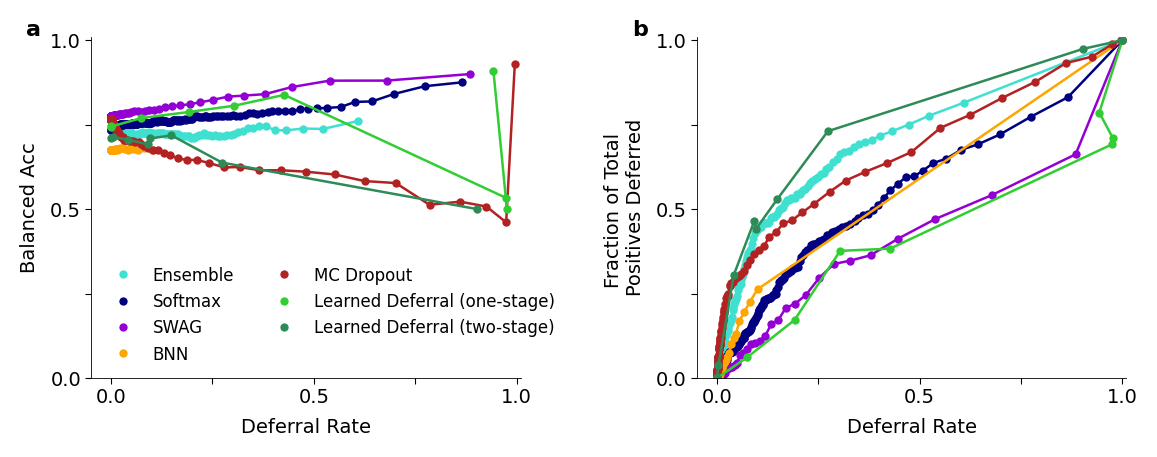

In [59]:
def get_pos_rates(data, labels):
    values, counts = np.unique(labels, return_counts=True)
    pos_rate = data[:, 3] / counts[1]
    return pos_rate

# Prepare positive rates
pos_rates = {
    'Ensemble': get_pos_rates(data_ensemble, labels),
    'Softmax': get_pos_rates(data_single, labels),
    'SWAG': get_pos_rates(data_swag, labels),
    'BNN': get_pos_rates(data_bbb, labels),
    'MC Dropout': get_pos_rates(data_mc, labels),
    'Learned Deferral (one-stage)': get_pos_rates(data_deferral, labels),
    'Learned Deferral (two-stage)': get_pos_rates(data_deferral_liu, labels)
}


# Define methods
methods = [
    (data_ensemble, 'Ensemble', 'turquoise'),
    (data_single, 'Softmax', 'navy'),
    (data_swag, 'SWAG', 'darkviolet'),
    (data_bbb, 'BNN', 'orange'),
    (data_mc, 'MC Dropout', 'firebrick'),
    (data_deferral, 'Learned Deferral (one-stage)', 'limegreen'),
    (data_deferral_liu, 'Learned Deferral (two-stage)', 'seagreen')
]

with plt.style.context("./plot_style.txt"):
    fig, axes = plt.subplots(1, 2, figsize=(5.8, 2.3), sharex=True)

    # --- First subplot: Balanced Accuracy ---
    ax1 = axes[0]
    for data, label, color in methods:
        ax1.plot(
            data[:, 0], data[:, 1],
            marker='o', markersize=2,
            label=label, color=color,
            linewidth=0.9
        )

    ax1.set_ylim(0.3, 1.01)
    ax1.set_xlim(-0.05, 1.01)
    ax1.set_xlabel('Deferral Rate')
    ax1.set_ylabel('Balanced Acc')
    ax1.set_xticks(np.linspace(0, 1.0, 5))
    ax1.set_xticklabels(['0.0', '', '0.5', '', '1.0'])
    ax1.set_yticks(np.linspace(0, 1.0, 5))
    ax1.set_yticklabels(['0.0', '', '0.5', '', '1.0'])
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)

    # Add legend to the left plot
    legend_handles = [
        Line2D([0], [0], marker='o', color='w', label=label,
               markerfacecolor=color, markersize=4)
        for _, label, color in methods
    ]
    ax1.legend(handles=legend_handles, frameon=False, ncol=2, loc="lower left")

    # --- Second subplot: Fraction of Positives Deferred ---
    ax2 = axes[1]
    for data, label, color in methods:
        ax2.plot(
            data[:, 0], pos_rates[label],
            marker='o', markersize=2,
            label=label, color=color,
            linewidth=0.9
        )

    ax2.set_ylim(0.3, 1.01)
    ax2.set_xlim(-0.05, 1.01)
    ax2.set_xlabel('Deferral Rate')
    ax2.set_ylabel('Fraction of Total \nPositives Deferred')
    ax2.set_xticks(np.linspace(0, 1.0, 5))
    ax2.set_xticklabels(['0.0', '', '0.5', '', '1.0'])
    ax2.set_yticks(np.linspace(0, 1.0, 5))
    ax2.set_yticklabels(['0.0', '', '0.5', '', '1.0'])
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)

    ax1.text(-0.15, 1.05, "a", transform=ax1.transAxes,
         fontsize=8, fontweight='bold', va='top', ha='left')
    ax2.text(-0.15, 1.05, "b", transform=ax2.transAxes,
         fontsize=8, fontweight='bold', va='top', ha='left')

    fig.tight_layout()
    fig.savefig("in-domain.pdf", bbox_inches='tight', pad_inches=0)
    plt.show()


# Out of domain

**Question:** How well does the model recognise ood images and how sensitive is it to their level of ood?

## OOD = noise

In [60]:
# ood images: dataset includes half of the testset unchanged and
# the other half repeated five times with each repitions augmented with different levels of noise

hdf5_file_ood = h5py.File("/ood.h5", "r")
labels_noise = hdf5_file_ood["diagnosis"][:]
levels_ood = hdf5_file_ood["level"][:]

In [61]:
# loading model outputs
model_outs_ood = np.load("/model_outs_ood.npz")
ensemble = model_outs_ood["ensemble"]
single = model_outs_ood["single"]
deferral = model_outs_ood["deferral"]
model_outs_ood_liu = np.load("/model_outs_liu_ood.npz")
deferral_liu = model_outs_ood_liu["deferral_liu"]

deferral_liu = deferral_liu.reshape(-1, n_deferral, 3)
deferral_liu = np.delete(deferral_liu, [30430, 30431, 30432], 0)
print(deferral_liu.shape)
# remove last zero entries (due to batches)
ensemble = ensemble.reshape(-1, 10, 2)
ensemble = np.delete(ensemble, [30430, 30431, 30432], 0)
print(ensemble.shape)

single = single.reshape(-1, 2)
single = np.delete(single, [30430, 30431, 30432], 0)
print(single.shape)

deferral = deferral.reshape(-1, n_deferral, 3)
deferral = np.delete(deferral, [30430, 30431, 30432], 0)
print(deferral.shape)
model_outs_swag_ood = np.load("/SWAG_outs_ood.npz")
swag = model_outs_swag_ood["predictions"]
swag = np.swapaxes(swag,0,1)
model_outs_bbb_ood = np.load("/bbb_out_ood.npz")
bbb = model_outs_bbb_ood["predictions"]
model_outs_mcdropout_ood = np.load("/mcdropout_out_ood.npz")
mc = model_outs_mcdropout_ood["predictions"]

(30433, 10, 3)
(30433, 10, 2)
(30433, 2)
(30433, 10, 3)
(30433, 2, 3)


In [62]:
def compute_metrics(name, targets, predictions):
    fpr, tpr, _ = roc_curve(targets, predictions[:, 1])
    roc_auc = auc(fpr, tpr)
    pred_labels = predictions.argmax(axis=1)
    bacc = balanced_accuracy_score(targets, pred_labels)
    cm = confusion_matrix(targets, pred_labels)
    per_class_acc = cm.diagonal() / cm.sum(axis=1)
    return {
        "Model": name,
        "AUC": roc_auc,
        "Balanced Accuracy": bacc,
        "Per-Class Accuracy": per_class_acc
    }

results = []

metrics_bbb = compute_metrics("BNN", model_outs_bbb_ood["targets"], bbb.mean(axis=1))
results.append(metrics_bbb)

metrics_mc = compute_metrics("MC Dropout", model_outs_mcdropout_ood["targets"], mc.mean(axis=1))
results.append(metrics_mc)

metrics_swag = compute_metrics("SWAG", model_outs_swag_ood["targets"], swag.mean(axis=1))
results.append(metrics_swag)

metrics_ensemble = compute_metrics("Ensemble", labels_noise, ensemble.mean(axis=1))
results.append(metrics_ensemble)

metrics_single = compute_metrics("Softmax", labels_noise, single)
results.append(metrics_single)

# deferral
fpr_deferral, tpr_deferral, _ = roc_curve(labels_noise, deferral[:, 9, 1])
roc_auc_deferral = metrics.auc(fpr_deferral, tpr_deferral)
bacc_deferral = balanced_accuracy_score(labels_noise, deferral[:, 9].argmax(axis=1))
cm = confusion_matrix(labels_noise, deferral[:, 9].argmax(axis=1))
per_class_acc_deferral = cm.diagonal() / cm.sum(axis=1)
metrics_deferral = {
        "Model": "Deferral Model",
        "AUC": roc_auc_deferral,
        "Balanced Accuracy": bacc_deferral,
        "Per-Class Accuracy": per_class_acc_deferral
    }
results.append(metrics_deferral)

# deferral liu
fpr_deferral_liu, tpr_deferral_liu, _ = roc_curve(labels_noise, deferral_liu[:, 0, 1])
roc_auc_deferral_liu = metrics.auc(fpr_deferral_liu, tpr_deferral_liu)
bacc_deferral_liu = balanced_accuracy_score(labels_noise, deferral_liu[:, 0].argmax(axis=1))
cm = confusion_matrix(labels_noise, deferral_liu[:, 0].argmax(axis=1))
per_class_acc_deferral_liu = cm.diagonal() / cm.sum(axis=1)
metrics_deferral_liu = {
        "Model": "Deferral Model Liu et al.",
        "AUC": roc_auc_deferral_liu,
        "Balanced Accuracy": bacc_deferral_liu,
        "Per-Class Accuracy": per_class_acc_deferral_liu
    }
results.append(metrics_deferral_liu)

df_results = pd.DataFrame(results)
df_results["Per-Class Accuracy"] = df_results["Per-Class Accuracy"].apply(lambda x: np.round(x, 3))
df_results[["AUC", "Balanced Accuracy"]] = df_results[["AUC", "Balanced Accuracy"]].round(3)
print(df_results.to_string(index=False))

                    Model   AUC  Balanced Accuracy Per-Class Accuracy
                      BNN 0.748              0.643     [0.963, 0.323]
               MC Dropout 0.728              0.692     [0.918, 0.466]
                     SWAG 0.756              0.727     [0.887, 0.567]
                 Ensemble 0.764              0.645     [0.987, 0.302]
                  Softmax 0.729              0.655     [0.963, 0.347]
           Deferral Model 0.675              0.648     [0.948, 0.348]
Deferral Model Liu et al. 0.778              0.616     [0.991, 0.241]


In [63]:
data_ensemble_noise, data_single_noise, data_deferral_noise, data_deferral_liu_noise, data_swag_noise, data_mc_noise, data_bbb_noise = get_data_level(ensemble, single, deferral, deferral_liu, swag, mc, bbb, levels_ood, labels_noise)

/tmp/ipykernel_1702632/799846855.py:46: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(left=0.1)
/tmp/ipykernel_1702632/799846855.py:50: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


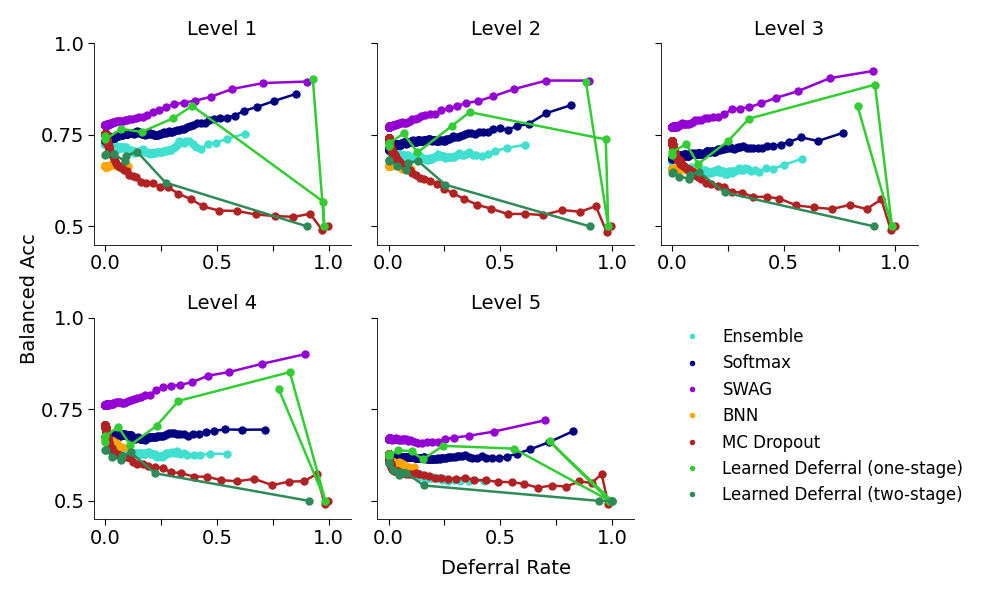

In [64]:
methods = [
    (data_ensemble_noise, 'Ensemble', 'turquoise'),
    (data_single_noise, 'Softmax', 'navy'),
    (data_swag_noise, 'SWAG', 'darkviolet'),
    (data_bbb_noise, 'BNN', 'orange'),
    (data_mc_noise, 'MC Dropout', 'firebrick'),
    (data_deferral_noise, 'Learned Deferral (one-stage)', 'limegreen'),
    (data_deferral_liu_noise, 'Learned Deferral (two-stage)', 'seagreen')
]


with plt.style.context("./plot_style.txt"):
    fig, axes = plt.subplots(2, 3, figsize=(5, 3), sharey=True)  # 3x2 grid for 5 plots
    axes = axes.flatten()

    for ood_level in range(5):  # Loop through 5 OOD levels
        ax = axes[ood_level]
        for model, label, color in methods:
            x = model[ood_level, :, 0]
            bacc = model[ood_level, :, 1]
            ax.plot(x, bacc, marker='o', label=label, markersize=2, color=color,linewidth=0.9)

        ax.set_title(f"Level {ood_level+1}", fontsize=7)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        
        ax.set_ylim(0.45, 1)
        ax.set_xlim(-0.05, 1.1)
        ax.set_xticks(np.linspace(0, 1.0, 5))
        ax.set_xticklabels(['0.0', '', '0.5', '', '1.0'])
        ax.set_yticks(np.linspace(0.5, 1.0, 3))
        ax.set_yticklabels(['0.5', '0.75', '1.0'])

   # axes[0].set_ylabel("Balanced Acc")
    axes[4].set_xlabel("Deferral Rate")

    # Add legend to the left plot
    legend_handles = [
        Line2D([0], [0], marker='o', color='w', label=label,
               markerfacecolor=color, markersize=3)
        for _, label, color in methods
    ]
    axes[5].legend(handles=legend_handles, frameon=False, ncol=1, loc="lower left")
    axes[5].axis("off")

    plt.subplots_adjust(left=0.1)
    fig.text(0, 0.5, "Balanced Acc", va='center', rotation='vertical', fontsize=7)


    plt.tight_layout()
    fig.savefig("noise_level.pdf", bbox_inches='tight', pad_inches=0)
    plt.show()


In [65]:
# get only level three
mask_level = (levels_ood == 3) | (levels_ood == 0)
ensemble_level = ensemble[mask_level]
single_level = single[mask_level]
deferral_level = deferral[mask_level]
deferral_liu_level = deferral_liu[mask_level]
swag_level = swag[mask_level]
mc_level = mc[mask_level]
bbb_level = bbb[mask_level]
labels_noise_level = labels_noise[mask_level]

In [66]:
# bAcc witout replacement
data_ensemble_noise, data_single_noise, data_deferral_noise, data_deferral_liu_noise, data_swag_noise, data_mc_noise, data_bbb_noise = get_data(ensemble_level, single_level, deferral_level, deferral_liu_level, swag_level, mc_level, bbb_level, labels_noise_level)

## OOD = blur

In [67]:
# ood images: dataset includes half of the testset unchanged and
# the other half repeated five times with each repitions augmented with different levels of noise

hdf5_file_ood = h5py.File("/ood_blur.h5", "r")
labels_blur = hdf5_file_ood["diagnosis"][:]
levels_ood = hdf5_file_ood["level"][:]

In [68]:
# loading model outputs
model_outs_ood = np.load("/model_outs_ood_blur.npz")
ensemble = model_outs_ood["ensemble"]
single = model_outs_ood["single"]
deferral = model_outs_ood["deferral"]
model_outs_ood_liu = np.load("/model_outs_liu_ood_blur.npz")
deferral_liu = model_outs_ood_liu["deferral_liu"]

deferral_liu = deferral_liu.reshape(-1, n_deferral, 3)
deferral_liu = np.delete(deferral_liu, [30430, 30431, 30432], 0)
print(deferral_liu.shape)
# remove last zero entries (due to batches)
ensemble = ensemble.reshape(-1, 10, 2)
ensemble = np.delete(ensemble, [30430, 30431, 30432], 0)
print(ensemble.shape)

single = single.reshape(-1, 2)
single = np.delete(single, [30430, 30431, 30432], 0)
print(single.shape)

deferral = deferral.reshape(-1, n_deferral, 3)
deferral = np.delete(deferral, [30430, 30431, 30432], 0)
print(deferral.shape)
model_outs_swag_ood = np.load("/SWAG_outs_ood_blur.npz")
swag = model_outs_swag_ood["predictions"]
swag = np.swapaxes(swag,0,1)
print(swag.shape)
model_outs_bbb_ood = np.load("/bbb_out_ood_blur.npz")
bbb = model_outs_bbb_ood["predictions"]
model_outs_mcdropout_ood = np.load("/mcdropout_out_ood_blur.npz")
mc = model_outs_mcdropout_ood["predictions"]

(30433, 10, 3)
(30433, 10, 2)
(30433, 2)
(30433, 10, 3)
(30433, 10, 2)


In [69]:
def compute_metrics(name, targets, predictions):
    fpr, tpr, _ = roc_curve(targets, predictions[:, 1])
    roc_auc = auc(fpr, tpr)
    pred_labels = predictions.argmax(axis=1)
    bacc = balanced_accuracy_score(targets, pred_labels)
    cm = confusion_matrix(targets, pred_labels)
    per_class_acc = cm.diagonal() / cm.sum(axis=1)
    return {
        "Model": name,
        "AUC": roc_auc,
        "Balanced Accuracy": bacc,
        "Per-Class Accuracy": per_class_acc
    }

results = []

metrics_bbb = compute_metrics("BNN", model_outs_bbb_ood["targets"], bbb.mean(axis=1))
results.append(metrics_bbb)

metrics_mc = compute_metrics("MC Dropout", model_outs_mcdropout_ood["targets"], mc.mean(axis=1))
results.append(metrics_mc)

metrics_swag = compute_metrics("SWAG", model_outs_swag_ood["targets"], swag.mean(axis=1))
results.append(metrics_swag)

metrics_ensemble = compute_metrics("Ensemble", labels_blur, ensemble.mean(axis=1))
results.append(metrics_ensemble)

metrics_single = compute_metrics("Softmax", labels_blur, single)
results.append(metrics_single)

# deferral
fpr_deferral, tpr_deferral, _ = roc_curve(labels_blur, deferral[:, 9, 1])
roc_auc_deferral = metrics.auc(fpr_deferral, tpr_deferral)
bacc_deferral = balanced_accuracy_score(labels_blur, deferral[:, 9].argmax(axis=1))
cm = confusion_matrix(labels_blur, deferral[:, 9].argmax(axis=1))
per_class_acc_deferral = cm.diagonal() / cm.sum(axis=1)
metrics_deferral = {
        "Model": "Deferral Model",
        "AUC": roc_auc_deferral,
        "Balanced Accuracy": bacc_deferral,
        "Per-Class Accuracy": per_class_acc_deferral
    }
results.append(metrics_deferral)

# deferral liu
fpr_deferral_liu, tpr_deferral_liu, _ = roc_curve(labels_blur, deferral_liu[:, 0, 1])
roc_auc_deferral_liu = metrics.auc(fpr_deferral_liu, tpr_deferral_liu)
bacc_deferral_liu = balanced_accuracy_score(labels_blur, deferral_liu[:, 0].argmax(axis=1))
cm = confusion_matrix(labels_blur, deferral_liu[:, 0].argmax(axis=1))
per_class_acc_deferral_liu = cm.diagonal() / cm.sum(axis=1)
metrics_deferral_liu = {
        "Model": "Deferral Model Liu et al.",
        "AUC": roc_auc_deferral_liu,
        "Balanced Accuracy": bacc_deferral_liu,
        "Per-Class Accuracy": per_class_acc_deferral_liu
    }
results.append(metrics_deferral_liu)

df_results = pd.DataFrame(results)
df_results["Per-Class Accuracy"] = df_results["Per-Class Accuracy"].apply(lambda x: np.round(x, 3))
df_results[["AUC", "Balanced Accuracy"]] = df_results[["AUC", "Balanced Accuracy"]].round(3)
print(df_results.to_string(index=False))

                    Model   AUC  Balanced Accuracy Per-Class Accuracy
                      BNN 0.782              0.684     [0.937, 0.431]
               MC Dropout 0.800              0.733     [0.782, 0.684]
                     SWAG 0.826              0.756     [0.736, 0.777]
                 Ensemble 0.822              0.730     [0.948, 0.512]
                  Softmax 0.787              0.730     [0.862, 0.598]
           Deferral Model 0.773              0.679     [0.605, 0.753]
Deferral Model Liu et al. 0.804              0.705     [0.962, 0.449]


In [ ]:
data_ensemble_blur, data_single_blur, data_deferral_blur, data_deferral_liu_blur, data_swag_blur, data_mc_blur, data_bbb_blur = get_data_level(ensemble, single, deferral, deferral_liu, swag, mc, bbb, levels_ood, labels_blur)

/tmp/ipykernel_1702632/1076809299.py:46: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(left=0.1)
/tmp/ipykernel_1702632/1076809299.py:50: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


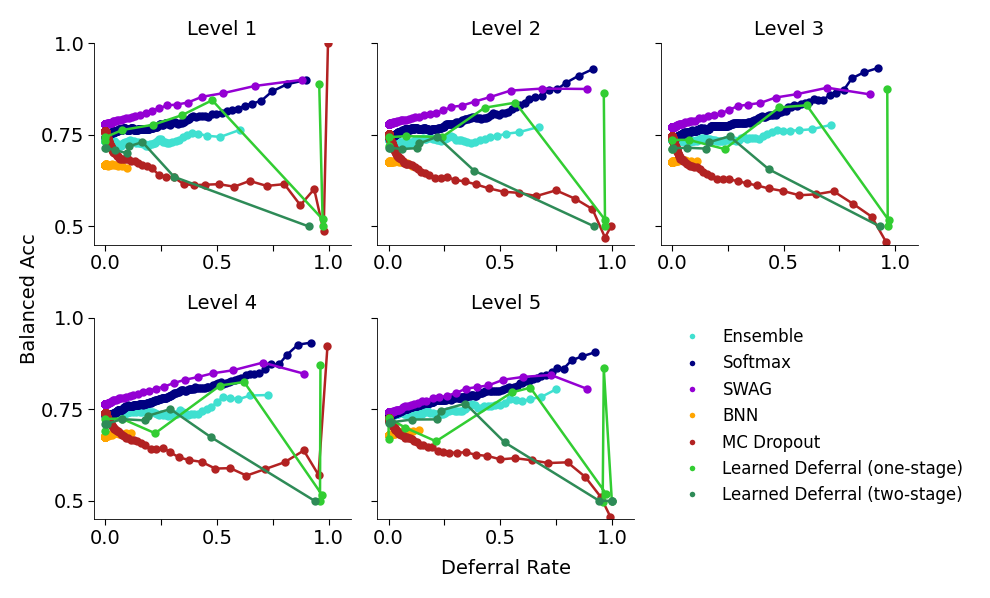

In [71]:

methods = [
    (data_ensemble_blur, 'Ensemble', 'turquoise'),
    (data_single_blur, 'Softmax', 'navy'),
    (data_swag_blur, 'SWAG', 'darkviolet'),
    (data_bbb_blur, 'BNN', 'orange'),
    (data_mc_blur, 'MC Dropout', 'firebrick'),
    (data_deferral_blur, 'Learned Deferral (one-stage)', 'limegreen'),
    (data_deferral_liu_blur, 'Learned Deferral (two-stage)', 'seagreen')
]


with plt.style.context("./plot_style.txt"):
    fig, axes = plt.subplots(2, 3, figsize=(5, 3), sharey=True)  # 3x2 grid for 5 plots
    axes = axes.flatten()

    for ood_level in range(5):  # Loop through 5 OOD levels
        ax = axes[ood_level]
        for model, label, color in methods:
            x = model[ood_level, :, 0]
            bacc = model[ood_level, :, 1]
            ax.plot(x, bacc, marker='o', label=label, markersize=2, color=color,linewidth=0.9)

        ax.set_title(f"Level {ood_level+1}", fontsize=7)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        
        ax.set_ylim(0.45, 1)
        ax.set_xlim(-0.05, 1.1)
        ax.set_xticks(np.linspace(0, 1.0, 5))
        ax.set_xticklabels(['0.0', '', '0.5', '', '1.0'])
        ax.set_yticks(np.linspace(0.5, 1.0, 3))
        ax.set_yticklabels(['0.5', '0.75', '1.0'])

   # axes[0].set_ylabel("Balanced Acc")
    axes[4].set_xlabel("Deferral Rate")

    # Add legend to the left plot
    legend_handles = [
        Line2D([0], [0], marker='o', color='w', label=label,
               markerfacecolor=color, markersize=3)
        for _, label, color in methods
    ]
    axes[5].legend(handles=legend_handles, frameon=False, ncol=1, loc="lower left")
    axes[5].axis("off")

    plt.subplots_adjust(left=0.1)
    fig.text(0, 0.5, "Balanced Acc", va='center', rotation='vertical', fontsize=7)


    plt.tight_layout()
    fig.savefig("blur_level.pdf",  bbox_inches='tight', pad_inches=0)
    plt.show()


In [72]:
# get only level three
mask_level = (levels_ood == 3) | (levels_ood == 0)
ensemble_level = ensemble[mask_level]
single_level = single[mask_level]
deferral_level = deferral[mask_level]
deferral_liu_level = deferral_liu[mask_level]
swag_level = swag[mask_level]
mc_level = mc[mask_level]
bbb_level = bbb[mask_level]
labels_blur_level = labels_blur[mask_level]

In [73]:
# bAcc witout replacement
data_ensemble_blur, data_single_blur, data_deferral_blur, data_deferral_liu_blur, data_swag_blur, data_mc_blur, data_bbb_blur = get_data(ensemble_level, single_level, deferral_level, deferral_liu_level, swag_level, mc_level, bbb_level, labels_blur_level)

## Combined noise and blur

In [74]:
def get_pos_rates(data, labels):
    values, counts = np.unique(labels, return_counts=True)
    pos_rate = data[:, 3] / counts[1]
    return pos_rate

# Prepare positive rates
pos_rates_blur = {
    'Ensemble': get_pos_rates(data_ensemble_blur, labels_blur_level),
    'Softmax': get_pos_rates(data_single_blur, labels_blur_level),
    'SWAG': get_pos_rates(data_swag_blur, labels_blur_level),
    'BNN': get_pos_rates(data_bbb_blur, labels_blur_level),
    'MC Dropout': get_pos_rates(data_mc_blur, labels_blur_level),
    'Learned Deferral (one-stage)': get_pos_rates(data_deferral_blur, labels_blur_level),
    'Learned Deferral (two-stage)': get_pos_rates(data_deferral_liu_blur, labels_blur_level)
}

pos_rates_noise = {
    'Ensemble': get_pos_rates(data_ensemble_noise, labels_noise_level),
    'Softmax': get_pos_rates(data_single_noise, labels_noise_level),
    'SWAG': get_pos_rates(data_swag_noise, labels_noise_level),
    'BNN': get_pos_rates(data_bbb_noise, labels_noise_level),
    'MC Dropout': get_pos_rates(data_mc_noise, labels_noise_level),
    'Learned Deferral (one-stage)': get_pos_rates(data_deferral_noise, labels_noise_level),
    'Learned Deferral (two-stage)': get_pos_rates(data_deferral_liu_noise, labels_noise_level)
}

methods_blur = [
    (data_ensemble_blur, 'Ensemble', 'turquoise'),
    (data_single_blur, 'Softmax', 'navy'),
    (data_swag_blur, 'SWAG', 'darkviolet'),
    (data_bbb_blur, 'BNN', 'orange'),
    (data_mc_blur, 'MC Dropout', 'firebrick'),
    (data_deferral_blur, 'Learned Deferral (one-stage)', 'limegreen'),
    (data_deferral_liu_blur, 'Learned Deferral (two-stage)', 'seagreen')
]

methods_noise = [
    (data_ensemble_noise, 'Ensemble', 'turquoise'),
    (data_single_noise, 'Softmax', 'navy'),
    (data_swag_noise, 'SWAG', 'darkviolet'),
    (data_bbb_noise, 'BNN', 'orange'),
    (data_mc_noise, 'MC Dropout', 'firebrick'),
    (data_deferral_noise, 'Learned Deferral (one-stage)', 'limegreen'),
    (data_deferral_liu_noise, 'Learned Deferral (two-stage)', 'seagreen')
]

/tmp/ipykernel_1702632/272195975.py:43: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


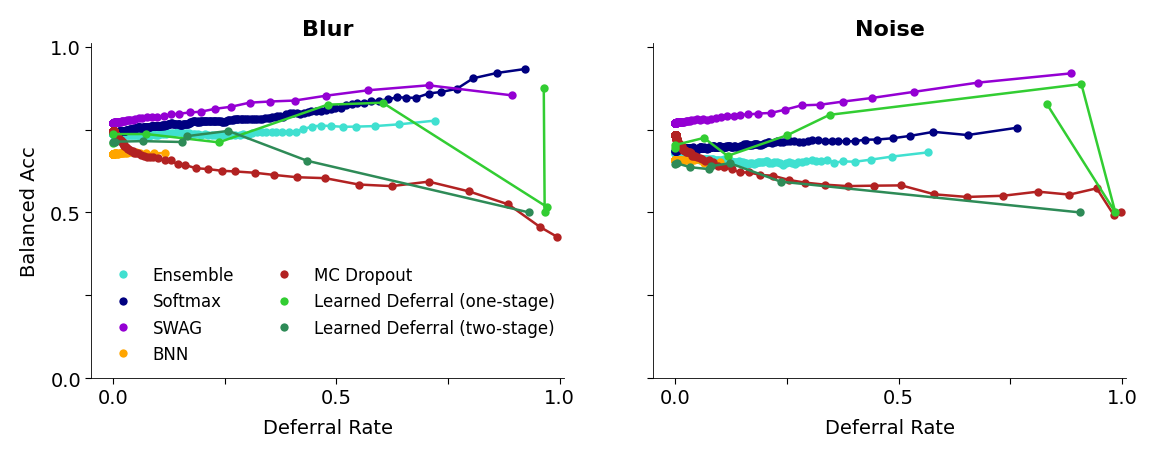

In [75]:
with plt.style.context("./plot_style.txt"):
    fig, axes = plt.subplots(1, 2, figsize=(5.8, 2.3), sharex=True, sharey=True)
    for col_idx, (methods, col_title) in enumerate([
        (methods_blur, 'Blur'),
        (methods_noise, 'Noise')
    ]):
        # Left column: bAcc
        ax = axes[col_idx]
        for data, label, color in methods:
            ax.plot(data[:, 0], data[:, 1], marker='o', markersize=2,
                     label=label, color=color, linewidth=0.9)
        ax.set_ylim(0.3, 1.01)
        ax.set_xlim(-0.05, 1.01)
        ax.set_xlabel("Deferral Rate")
        ax.set_yticks(np.linspace(0, 1.0, 5))
        ax.set_yticklabels(['0.0', '', '0.5', '', '1.0'])
        ax.set_xticks(np.linspace(0, 1.0, 5))
        ax.set_xticklabels(['0.0', '', '0.5', '', '1.0'])
        if col_idx == 0:
            ax.set_ylabel("Balanced Acc")
        ax.set_title(col_title, fontsize=8, fontweight='bold')

        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

        # Add legend to the top-left plot
    legend_handles = [
        Line2D([0], [0], marker='o', color='w', label=label,
               markerfacecolor=color, markersize=4)
        for _, label, color in methods_blur
    ]
    
    axes[0].legend(handles=legend_handles[:], frameon=False, ncol=2, loc="lower left")



    fig.tight_layout()
    fig.savefig("deferral_noise_blur.pdf",  bbox_inches='tight', pad_inches=0)
    plt.show()

/tmp/ipykernel_1702632/2793276727.py:42: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


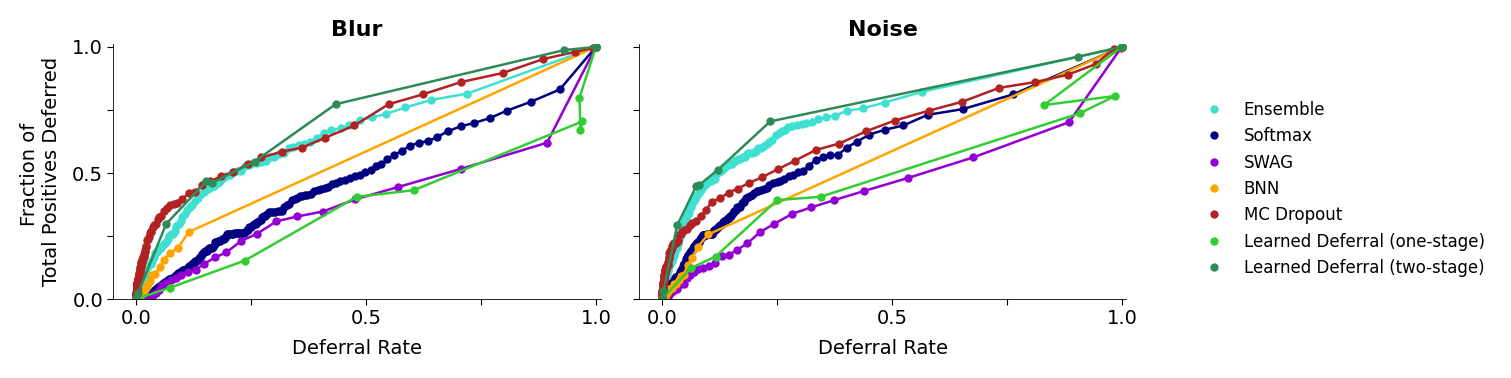

In [76]:
with plt.style.context("./plot_style.txt"):
    fig, axes = plt.subplots(1, 2, figsize=(5.8, 1.9), sharex=True, sharey=True)
    for col_idx, (methods, pos_rates, col_title) in enumerate([
        (methods_blur, pos_rates_blur, 'Blur'),
        (methods_noise, pos_rates_noise, 'Noise')
    ]):
        # Left column: bAcc
        ax = axes[col_idx]
        for data, label, color in methods:
            ax.plot(data[:, 0], pos_rates[label], marker='o', markersize=2,
                     label=label, color=color, linewidth=0.9)
        ax.set_ylim(0.3, 1.01)
        ax.set_xlabel("Deferral Rate")
        ax.set_xlim(-0.05, 1.01)
        ax.set_yticks(np.linspace(0, 1.0, 5))
        ax.set_yticklabels(['0.0', '', '0.5', '', '1.0'])
        ax.set_xticks(np.linspace(0, 1.0, 5))
        ax.set_xticklabels(['0.0', '', '0.5', '', '1.0'])
        if col_idx == 0:
            ax.set_ylabel("Fraction of \nTotal Positives Deferred")
        ax.set_title(col_title, fontsize=8, fontweight='bold')

        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

        # Add legend to the top-left plot
    legend_handles = [
        Line2D([0], [0], marker='o', color='w', label=label,
               markerfacecolor=color, markersize=4)
        for _, label, color in methods_blur
    ]
    fig.legend(handles=legend_handles, frameon=False, ncol=1,
           loc='center left', bbox_to_anchor=(1.02, 0.5))
    
    fig.tight_layout()
    fig.savefig("positives_noise_blur.pdf",  bbox_inches='tight', pad_inches=0)
    plt.show()